In [94]:
!pip install lexical-diversity nltk 
!pip install openai
!pip install xgboost


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 31.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [31]:
import pandas as pd 
import nltk
nltk.download('punkt')
from lexical_diversity import lex_div as ld
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kimyingwong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [32]:
def compute_lexical_measures(text):
    tokens = word_tokenize(text)  # More accurate than split()
    mattr_50 = ld.mattr(tokens, window_length=50)
    mtld = ld.mtld(tokens)
    ttr = ld.ttr(tokens)
    return pd.Series({
        'mattr_50': mattr_50,
        'mtld': mtld,
        'ttr': ttr
    })

In [33]:
train_df = pd.read_csv("./learning-agency-lab-automated-essay-scoring-2/train.csv")

In [34]:
lexical_features = train_df['full_text'].apply(compute_lexical_measures)
df_lex = pd.concat([train_df, lexical_features], axis=1)

In [122]:
df_lex

,essay_id,full_text,score,predicted_score,mattr_50,mtld,ttr
0,000d118,Many people have car where they live. The thin...,3,2,0.826210,86.951661,0.455046
1,000fe60,I am a scientist at NASA that is discussing th...,3,2,0.795963,71.472059,0.452830
2,001ab80,People always wish they had the same technolog...,4,4,0.821583,91.302984,0.401653
3,001bdc0,"We all heard about Venus, the planet without a...",4,3,0.815844,107.736209,0.471624
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,3,0.737453,55.620344,0.373206
...,...,...,...,...,...,...,...
95,01c3e09,Venus or also called the evening star is one o...,1,2,0.757529,54.750000,0.506849
96,01c46fa,"The article called "" Making Mona Lisa Smile"" d...",3,3,0.846400,129.495134,0.555874
97,01c5073,My views on technology being used to read stud...,3,3,0.818719,90.612651,0.460905
98,01c5750,Our curosity leads us to many things despite t...,3,3,0.827483,94.894188,0.440310


In [63]:
import os
from dotenv import load_dotenv
from openai import OpenAI

# Load your API key from .env
load_dotenv()
client = OpenAI()

rubric_text = """
Use the following rubric to assign a holistic score from 1 (lowest) to 6 (highest). Only return the number.

SCORE OF 6: Mastery with clear focus, strong argument, excellent vocabulary, varied syntax, and minimal grammar issues.  
SCORE OF 5: Strong writing with occasional issues, coherent argument, appropriate vocabulary, and some sentence variety.  
SCORE OF 4: Adequate response, basic structure, competent vocabulary, and some grammar issues.  
SCORE OF 3: Developing response, limited structure, weak vocabulary, or noticeable grammar issues.  
SCORE OF 2: Weak argument, poor organization, limited vocabulary, and frequent grammar errors.  
SCORE OF 1: Severely flawed with no clear argument, incoherent structure, and pervasive grammar problems.
"""

essay = train_df.loc[0, "full_text"] 

# Use chat model with correct format
def score_essay(essay_text: str) -> int:
    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {
                    "role": "system",
                    "content": f"""
You are an AI essay grader. Below is a grading rubric and a student essay.  
Evaluate the essay using the rubric and return only a number from 1 to 6.

Rubric:
{rubric_text}
"""
                },
                {
                    "role": "user",
                    "content": essay_text
                }
            ],
            temperature=0,
            max_tokens=100
        )
        result = response.choices[0].message.content.strip()
        return int(result)
    except Exception as e:
        print(f"Error: {e}")
        return -1  # Return a fallback value like -1 if an error occurs


print("Predicted Score:", response.choices[0].message.content.strip())


Predicted Score: 2


In [65]:
train_df['predicted_score'] = train_df.loc[:99, 'full_text'].apply(score_essay)


,essay_id,full_text,score,predicted_score
0,000d118,Many people have car where they live. The thin...,3,2.0
1,000fe60,I am a scientist at NASA that is discussing th...,3,2.0
2,001ab80,People always wish they had the same technolog...,4,4.0
3,001bdc0,"We all heard about Venus, the planet without a...",4,3.0
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,3.0
...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,NaN
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,NaN
17304,fff016d,If you don't like sitting around all day than ...,2,NaN
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,NaN


In [66]:
lexical_features = train_df['full_text'].apply(compute_lexical_measures)

In [67]:
df_lex = pd.concat([train_df, lexical_features], axis=1)

In [70]:
df_lex.dropna(inplace=True)

In [72]:
df_lex

,essay_id,full_text,score,predicted_score,mattr_50,mtld,ttr
0,000d118,Many people have car where they live. The thin...,3,2.0,0.826210,86.951661,0.455046
1,000fe60,I am a scientist at NASA that is discussing th...,3,2.0,0.795963,71.472059,0.452830
2,001ab80,People always wish they had the same technolog...,4,4.0,0.821583,91.302984,0.401653
3,001bdc0,"We all heard about Venus, the planet without a...",4,3.0,0.815844,107.736209,0.471624
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,3.0,0.737453,55.620344,0.373206
...,...,...,...,...,...,...,...
95,01c3e09,Venus or also called the evening star is one o...,1,2.0,0.757529,54.750000,0.506849
96,01c46fa,"The article called "" Making Mona Lisa Smile"" d...",3,3.0,0.846400,129.495134,0.555874
97,01c5073,My views on technology being used to read stud...,3,3.0,0.818719,90.612651,0.460905
98,01c5750,Our curosity leads us to many things despite t...,3,3.0,0.827483,94.894188,0.440310


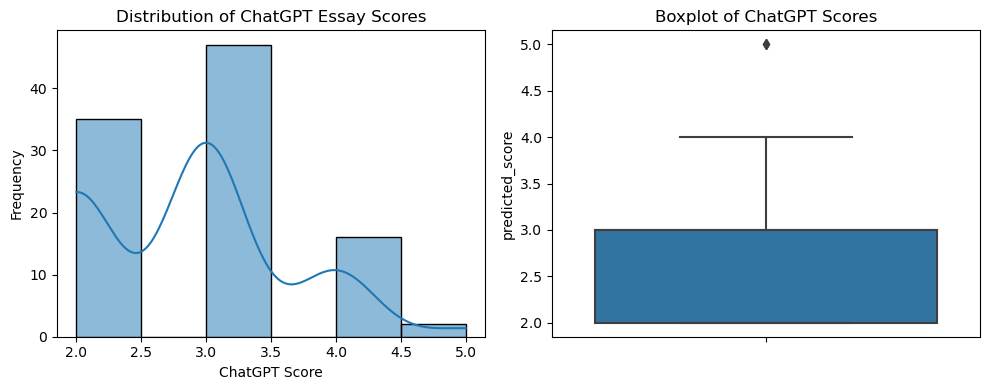

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of ChatGPT scores
plt.figure(figsize=(10, 4))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df_lex['predicted_score'], bins=6, kde=True)
plt.title("Distribution of ChatGPT Essay Scores")
plt.xlabel("ChatGPT Score")
plt.ylabel("Frequency")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=df_lex['predicted_score'])
plt.title("Boxplot of ChatGPT Scores")

plt.tight_layout()
plt.show()


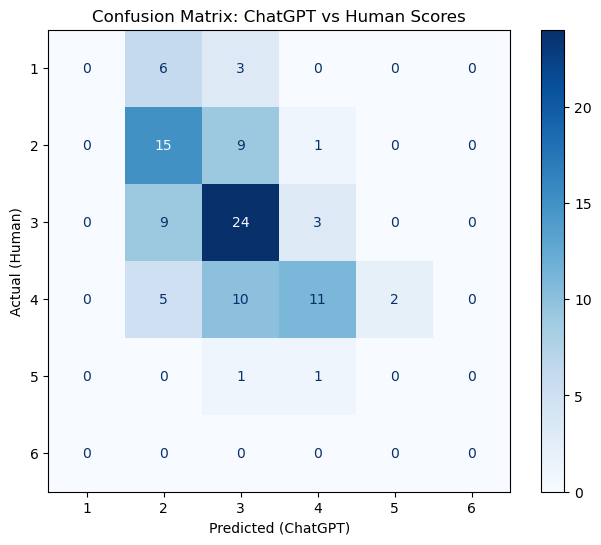

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make sure both columns are integers
df_lex["score"] = df_lex["score"].astype(int)
df_lex["predicted_score"] = df_lex["predicted_score"].astype(int)

# Compute confusion matrix
cm = confusion_matrix(df_lex["score"], df_lex["predicted_score"], labels=[1, 2, 3, 4, 5, 6])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3, 4, 5, 6])

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Confusion Matrix: ChatGPT vs Human Scores")
plt.xlabel("Predicted (ChatGPT)")
plt.ylabel("Actual (Human)")
plt.show()


In [79]:
from sklearn.metrics import cohen_kappa_score

# Ensure both columns are integers
df_lex["score"] = df_lex["score"].astype(int)
df_lex["predicted_score"] = df_lex["predicted_score"].astype(int)

# Calculate QWK (Quadratic Weighted Kappa)
qwk = cohen_kappa_score(df_lex["score"], df_lex["predicted_score"], weights='quadratic')

# Output the QWK score
print("Quadratic Weighted Kappa (QWK):", qwk)


Quadratic Weighted Kappa (QWK): 0.4760969220694171


/Users/kimyingwong/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


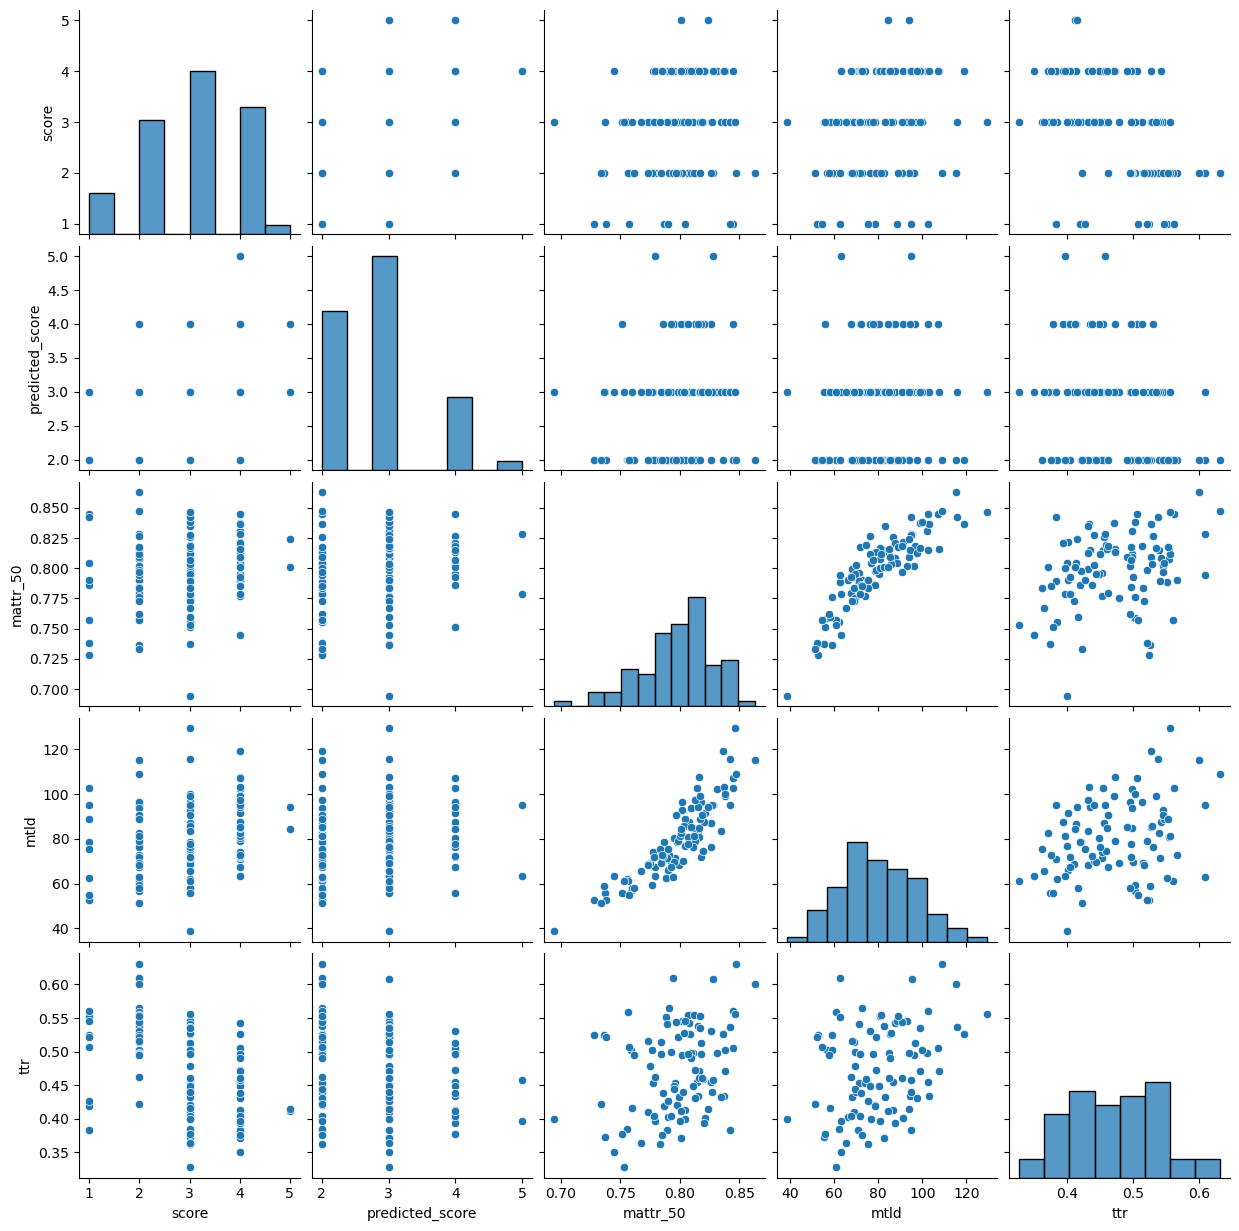

In [82]:
# pairplot for the label < == > predictors 

# Select columns for pairplot (adjust based on your data)
selected_columns = ['score', 'predicted_score', 'mattr_50', 'mtld', 'ttr']

# Create a pairplot
sns.pairplot(df_lex[selected_columns])

# Show the plot
plt.show()


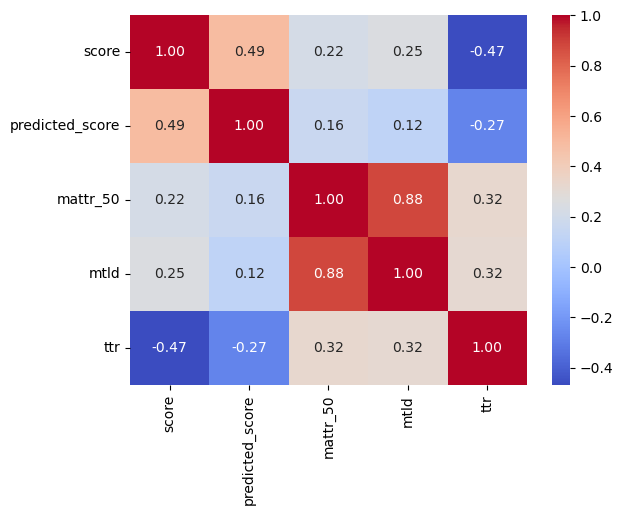

In [85]:

# Select columns for correlation heatmap (adjust based on your data)
selected_columns = ['score', 'predicted_score', 'mattr_50', 'mtld', 'ttr']

# Compute correlation matrix
corr = df_lex[selected_columns].corr()

# Create heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

# Display the plot
plt.show()


In [86]:
## seperate the training and test set
from sklearn.model_selection import train_test_split

# Split the data
train_df, test_df = train_test_split(df_lex, test_size=0.4, random_state=42)

# Check the sizes
print(f"Training set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 60
Test set size: 40


In [119]:
from sklearn.ensemble import RandomForestClassifier
# Assuming train_df has the necessary features and 'score' as target
X_train = train_df[['predicted_score', 'mattr_50', 'mtld', 'ttr']]  # Example features
y_train = train_df['score']  # Human score as target

X_test = test_df[['predicted_score', 'mattr_50', 'mtld', 'ttr']]  # Example features

y_test = test_df['score']  # Human score as target

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')



In [120]:
qwk

0.489051094890511

In [121]:
y_pred

array([4, 2, 4, 4, 4, 4, 4, 2, 2, 4, 4, 4, 3, 4, 3, 3, 4, 4, 3, 3, 2, 3,
       4, 3, 2, 2, 2, 3, 3, 3, 2, 3, 3, 4, 3, 3, 4, 2, 2, 2])